In [1]:
# 코랩에서 시행시 설치해줘야함.
## 설치 완료 후 상위 메뉴에서 런타임 -> 세션 다시시작 해줘야함.

!pip install numpy==1.26.4
!pip install scipy==1.11.1
!pip install pandas==2.1.4
!pip install scikit-learn==1.4.2
!pip install joblib==1.3.0
!pip install catboost==1.2.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 986.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 38.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beha

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from scipy import sparse, special, stats

# Machine Learning
from sklearn.metrics import (
    mean_squared_error,
    roc_curve,
    roc_auc_score,
    accuracy_score
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score

# Parallel Processing
from joblib import Parallel, delayed
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial

# Data Structure and Iteration
from collections import defaultdict
from itertools import combinations, permutations

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# System and Utilities
import os
import re
import random
import warnings
import contextlib
import itertools
from typing import List, Set, Dict, Tuple, Optional
import json

# treat imbalanced data
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# 데이터 불러오기 (KMLE 데이터)

In [2]:
# KMLE
url = 'https://raw.githubusercontent.com/novicedata/Grove_CAT/refs/heads/main/data/KMLE.txt'
data = pd.read_csv(url, sep = '\t', header=None)
data.columns = [f'Q{i}' for i in range(1, 361)]

In [3]:
data

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q351,Q352,Q353,Q354,Q355,Q356,Q357,Q358,Q359,Q360
0,1,1,1,0,1,1,1,1,1,1,...,0,1,1,0,0,1,1,1,1,0
1,1,1,1,0,1,1,1,1,1,1,...,1,0,1,0,0,0,1,1,1,0
2,1,1,1,0,1,1,1,1,1,1,...,1,1,1,0,0,0,1,1,0,1
3,1,1,1,0,1,1,1,1,1,1,...,0,1,1,0,0,1,1,1,0,0
4,1,1,1,0,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,1,1,1,0,1,1,1,1,1,0,...,0,1,1,0,1,0,1,1,1,0
3255,1,1,1,0,1,1,1,1,1,1,...,0,1,1,0,0,1,1,0,0,0
3256,1,1,1,0,1,0,1,1,1,1,...,1,1,1,1,0,1,1,1,0,0
3257,1,1,1,0,1,1,0,1,1,1,...,0,1,1,1,0,1,1,1,0,0


# 데이터 정제

해당년도 채점 기준을 적용하여 모든 조건을 만족하는 경우만 Pass(1)로 코딩

In [4]:
# 데이터 형태 출력
print(f'raw : {data.shape}')
data.dropna(inplace=True)
print(f'After dropping NaN: {data.shape}')

# 각 구간별 점수 계산
data['score_1_20'] = data.iloc[:, 0:20].sum(axis=1)  # Q1-Q20 점수
data['score_21_80'] = data.iloc[:, 20:80].sum(axis=1)  # Q21-Q80 점수
data['score_81_360'] = data.iloc[:, 80:360].sum(axis=1)  # Q81-Q360 점수
data['score_total'] = data.iloc[:, 0:360].sum(axis=1)  # 전체 점수

# 각 구간별 Pass 여부 계산 (조건 만족 = True)
condition1 = data['score_1_20'] >= 8  # 첫 20문항 중 8개 이상
condition2 = data['score_21_80'] >= 24  # 중간 60문항 중 24개 이상
condition3 = data['score_81_360'] >= 112  # 마지막 280문항 중 112개 이상
condition4 = data['score_total'] >= 216  # 전체 360문항 중 216개 이상

# 모든 조건을 만족하는 경우만 Pass(1)로 코딩
data['final_result'] = (condition1 & condition2 & condition3 & condition4).astype(int)

# X와 y 분리
X = data.iloc[:, 0:360]  # 원본 문항 데이터
y = data['final_result']  # Pass/Fail 결과

# 결과 확인
print("\n첫 5개 데이터의 구간별 점수:")
print(data[['score_1_20', 'score_21_80', 'score_81_360', 'score_total', 'final_result']].head())

# Pass율 확인
pass_rate = (data['final_result'] == 1).mean() * 100
print(f"\n전체 Pass율: {pass_rate:.2f}%")

raw : (3259, 360)
After dropping NaN: (3259, 360)

첫 5개 데이터의 구간별 점수:
   score_1_20  score_21_80  score_81_360  score_total  final_result
0          18           51           222          291             1
1          17           39           206          262             1
2          15           43           199          257             1
3          17           49           207          273             1
4          18           39           192          249             1

전체 Pass율: 95.24%


In [5]:
y.value_counts()

,count
final_result,
1,3104
0,155


### SMOTE + ENN 적용

In [6]:
# SMOTE + ENN 적용
smote_enn = SMOTEENN(sampling_strategy=0.3, random_state = 42)  # 비율을 0.3 정도로 조정
X, y = smote_enn.fit_resample(X, y)

In [7]:
y.value_counts()

,count
final_result,
1,3101
0,927


# CATBoost 적합

In [8]:
def train_catboost(X_train, y_train, X_test, y_test,
                   max_depth=3,
                   n_estimators=100,
                   learning_rate=1,
                   subsample=0.5,
                   min_child_samples=1,
                   random_state=42,
                   auto_class_weights=None):
    """
    주어진 파라미터로 CatBoost 모델을 학습시키는 함수입니다.
    :param X_train: 학습 데이터
    :param y_train: 학습 데이터의 레이블
    :param X_test: 테스트 데이터
    :param y_test: 테스트 데이터의 레이블
    :param max_depth: 트리의 최대 깊이 (default: 3)
    :param n_estimators: 생성할 트리의 수 (default: 100)
    :param learning_rate: 학습률 (default: 1)
    :param colsample_bylevel: 각 레벨에서 사용할 특성의 비율 (default: 0.5)
    :param subsample: 각 트리가 사용할 데이터의 비율 (default: 0.5)
    :param min_child_samples: 리프 노드의 최소 샘플 수 (default: 1)
    :param random_state: 랜덤 시드 (default: 42)
    :param auto_class_weights: 클래스 가중치 자동 설정 (default: None)
    :return: 학습된 모델과 파라미터
    """
    # 모델 파라미터 설정
    params = {
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'learning_rate': learning_rate,
        'depth': max_depth,
        'subsample': subsample,
        'grow_policy' : 'Lossguide',
        'random_seed': random_state,
        'iterations': n_estimators,
        'verbose': False,
        'thread_count': -1,
        'auto_class_weights': auto_class_weights
    }

    # Pool 생성
    train_pool = Pool(data=X_train, label=y_train)
    test_pool = Pool(data=X_test, label=y_test)

    # 모델 생성 및 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool,
              eval_set=test_pool,
              verbose=False)

    # 학습 데이터에 대한 예측 및 AUC 계산
    y_pred_train = model.predict_proba(train_pool)[:, 1]
    train_auc = roc_auc_score(y_train, y_pred_train)
    print(f"Final model AUC on train data: {train_auc}")

    # 테스트 데이터에 대한 예측 및 AUC 계산
    y_pred_test = model.predict_proba(test_pool)[:, 1]
    test_auc = roc_auc_score(y_test, y_pred_test)
    print(f"Final model AUC on test data: {test_auc}")

    return model, params


# Grove 코드

### 초기화 및 캐싱 메커니즘:

'__init__' 함수에서 세 가지 캐시 딕셔너리를 초기화:

1. _path_cache: 트리 경로 정보를 저장

2. _feature_cache: 각 트리가 사용하는 특성(feature) 집합을 저장

3. _prediction_cache: 트리별 예측값을 저장




### 트리 구조 분석:

get_tree_paths: 트리의 모든 가능한 경로와 각 경로에서 사용하는 특성들을 추출.

extract_features_from_node: 재귀적으로 트리 노드를 순회하며 사용된 특성들을 추출.

extract_tree_features: CatBoost 모델을 JSON 형식으로 저장하고 각 트리별로 사용된 모든 특성을 분석.

get_path_features_from_node: 특정 노드에서 시작하여 가능한 모든 경로의 특성 집합을 추출.


### 메모리 최적화:

optimize_numeric_dtypes: 수치형 데이터의 데이터 타입을 최적화하여 메모리 사용량을 줄임.

_temporary_pool: 컨텍스트 매니저를 통해 메모리를 효율적으로 관리.


### 트리 조합 분석:

calculate_item_range: 주어진 트리 조합에서 사용자가 받게 될 최소/최대 문항 수를 계산.

find_optimal_tree_groups: 지정된 트리 개수 범위를 만족하고 필수 특성을 포함하는 모든 가능한 트리 조합을 찾음.

get_tree_predictions: 메모리 효율적인 방식으로 특정 트리의 예측값을 계산.


### 병렬 처리 및 결과 생성:

process_tree_groups_batch: 배치 단위로 트리 그룹을 처리하여 성능 지표를 계산.

create_results_dataframe: 분석 결과를 정리하여 데이터프레임으로 변환.


### 메인 분석 프로세스 (analyze 함수):

입력 데이터와 매개변수 검증

트리별 특성 추출

트리별 예측값 계산

유효한 트리 조합 탐색

병렬 처리를 통한 조합별 성능 평가

AUC 기준 상위 조합 필터링

최소/최대 문항 수 계산

결과 정리 및 반환


### 예측 기능 (predict 함수):

선택된 트리 조합만을 사용하여 학습 및 테스트 데이터에 대한 예측을 수행.

각 트리의 예측값을 합산한 후 시그모이드 함수를 적용하여 확률값으로 변환.

In [9]:
class Grove:
    def __init__(self):
        # 캐시 초기화: 트리 경로, feature, 예측값에 대한 캐시를 각각 딕셔너리로 생성
        self._path_cache: Dict[int, List[Dict]] = {}  # 트리 경로 캐시
        self._feature_cache: Dict[int, Set[str]] = {}  # feature 캐시
        self._prediction_cache: Dict[Tuple[int, int], np.ndarray] = {}  # 예측값 캐시

    def get_tree_paths(self, tree_data: Dict, splits: List[Dict], leaf_values: List[float], tree_idx: Optional[int] = None) -> List[Dict]:
        """
        주어진 트리 데이터를 바탕으로 모든 가능한 경로를 추출합니다.
        - 각 경로에서 만나게 되는 feature들을 추출하고, 리프 노드에서의 값을 기록합니다.
        - 캐시를 사용하여 동일한 트리에 대해 중복된 계산을 피합니다.
        """
        # 이미 경로가 캐시되어 있는 경우 즉시 반환하여 계산을 생략
        if tree_idx is not None and tree_idx in self._path_cache:
            return self._path_cache[tree_idx]

        paths = []  # 결과를 저장할 리스트. 각 요소는 하나의 경로에 해당

        def traverse_tree(node_idx=0, current_features=None):
            if current_features is None:
                current_features = set()  # 현재 경로에서 만난 feature 인덱스를 저장

            # 현재 노드가 리프 노드이거나 splits 범위를 벗어난 경우
            if node_idx >= len(splits) or "leaf_values" in splits[node_idx]:
                # 리프 노드의 값을 추출 (노드 안에 직접 있거나 외부 leaf_values에서 추출)
                leaf_value = splits[node_idx].get("leaf_values", leaf_values[node_idx - len(splits)])
                # 경로에 사용된 feature들과 리프 값을 저장
                paths.append({
                    'features': current_features.copy(),  # 집합을 복사하여 저장
                    'value': leaf_value
                })
                return  # 리프 노드이므로 재귀 종료

            # 내부 노드일 경우 split 정보 추출
            split = splits[node_idx]
            if "float_feature_index" in split:
                # 현재 노드에서 사용된 feature index를 집합에 추가
                current_features.add(split["float_feature_index"])

            # 자식 노드 인덱스를 추출 (명시적 인덱스가 없으면 이진트리 규칙 사용)
            left_idx = split.get("left_child_index", 2 * node_idx + 1)
            right_idx = split.get("right_child_index", 2 * node_idx + 2)

            # 왼쪽 자식이 존재하면 재귀적으로 탐색 (feature 집합 복사)
            if left_idx < len(splits):
                traverse_tree(left_idx, current_features.copy())

            # 오른쪽 자식이 존재하면 재귀적으로 탐색
            if right_idx < len(splits):
                traverse_tree(right_idx, current_features.copy())

        # 트리 순회를 루트 노드(0번 인덱스)부터 시작
        traverse_tree()

        # 트리 인덱스가 주어졌다면 캐시에 결과 저장
        if tree_idx is not None:
            self._path_cache[tree_idx] = paths

        return paths  # 경로 리스트 반환


    def extract_features_from_node(self, node):
        """
        트리 노드를 재귀적으로 순회하면서 feature를 추출합니다.
        - 각 노드가 split을 가지고 있으면 해당 feature를 추출하고,
        - 왼쪽과 오른쪽 자식 노드에서도 동일한 작업을 수행합니다.
        """
        features = set()  # 최종적으로 반환할 feature 인덱스를 저장할 집합

        # 현재 노드가 split 조건을 가지고 있는 경우
        if 'split' in node:
            split = node['split']  # split 정보 추출
            if 'float_feature_index' in split:
                # split에서 사용된 float feature 인덱스를 추가
                features.add(split['float_feature_index'])

        # 왼쪽 자식 노드가 존재하고, 그것이 딕셔너리 형식일 경우
        if 'left' in node and isinstance(node['left'], dict):
            # 왼쪽 서브트리에서 추출한 feature들을 병합
            features.update(self.extract_features_from_node(node['left']))

        # 오른쪽 자식 노드가 존재하고, 그것이 딕셔너리 형식일 경우
        if 'right' in node and isinstance(node['right'], dict):
            # 오른쪽 서브트리에서 추출한 feature들을 병합
            features.update(self.extract_features_from_node(node['right']))

        return features  # 전체 서브트리에서 추출된 feature 인덱스 집합 반환


    def extract_tree_features(self, model: CatBoostClassifier or CatBoostRegressor, tree_idx: Optional[int] = None):
        """
        주어진 CatBoost 모델에서 트리별로 사용된 모든 feature를 추출합니다.
        - 모델을 JSON 형식으로 저장하고 이를 로드하여 트리 구조를 파싱합니다.
        - 캐시를 사용하여 동일한 트리에 대해 중복된 작업을 피합니다.
        """
        # 특정 트리 인덱스가 주어졌고, 해당 트리의 feature 정보가 캐시에 존재하면 즉시 반환
        if tree_idx is not None and tree_idx in self._feature_cache:
            return self._feature_cache[tree_idx]

        # 모델을 임시 JSON 파일로 저장 (CatBoost는 JSON 포맷으로 트리 구조 제공)
        temp_json_file = "temp_model.json"
        model.save_model(temp_json_file, format="json")

        # 저장한 JSON 파일을 열고 전체 모델 구조를 파싱
        with open(temp_json_file, "r") as f:
            model_json = json.load(f)

        trees = model_json["trees"]  # 트리 리스트를 추출

        if tree_idx is not None:
            # 단일 트리만 처리하는 경우
            tree_data = trees[tree_idx]  # 해당 트리 데이터 추출
            features = self.extract_features_from_node(tree_data)  # 해당 트리에서 feature 추출
            self._feature_cache[tree_idx] = features  # 캐시에 저장
            return features  # 추출된 feature 반환
        else:
            # 전체 트리에 대해 반복적으로 feature 추출 수행
            features = []
            for i, tree_data in enumerate(trees):
                # 각 트리에 대해 재귀 호출하여 feature 추출 (캐시가 자동 적용됨)
                features.append(self.extract_tree_features(model, i))
            return features  # 전체 트리에 대한 feature 리스트 반환


    def get_path_features_from_node(self, node, current_features=None):
        """
        주어진 노드에서 모든 가능한 경로의 feature 집합을 추출합니다.
        - 재귀적으로 왼쪽과 오른쪽 자식 노드를 순회하며 경로를 기록합니다.
        """
        if current_features is None:
            current_features = set()  # 현재까지의 경로에서 만난 feature들을 저장할 집합 초기화

        # 리프 노드에 도달한 경우
        if 'value' in node:
            return [current_features.copy()]  # 해당 경로에서의 feature 집합을 반환 (리스트에 담아서 반환)

        # 현재 노드가 split을 가지고 있으면 feature 인덱스를 추가
        if 'split' in node:
            current_features.add(node['split']['float_feature_index'])

        paths = []  # 모든 경로의 feature 집합을 저장할 리스트

        # 왼쪽 자식 노드가 존재하면 재귀적으로 탐색
        if 'left' in node:
            left_paths = self.get_path_features_from_node(node['left'], current_features.copy())
            paths.extend(left_paths)  # 왼쪽에서 얻은 경로들을 리스트에 추가

        # 오른쪽 자식 노드가 존재하면 재귀적으로 탐색
        if 'right' in node:
            right_paths = self.get_path_features_from_node(node['right'], current_features.copy())
            paths.extend(right_paths)  # 오른쪽에서 얻은 경로들을 리스트에 추가

        return paths  # 모든 리프 노드 경로에서의 feature 집합 리스트를 반환


    def calculate_item_range(self, model, tree_indices):
        """
        주어진 트리 인덱스들에 대해 최소/최대 문항 수를 계산합니다.
        - 트리의 가능한 경로들을 feature set으로 변환한 뒤, 모든 경로 조합을 계산하여 문항 수를 측정합니다.
        """
        # 각 트리의 가능한 경로들을 feature 집합으로 변환하여 저장할 리스트
        tree_feature_sets = []

        # 모델 구조를 JSON 형식으로 임시 파일에 저장
        temp_json_file = "temp_model.json"
        model.save_model(temp_json_file, format="json")

        # 저장한 JSON 파일을 열어서 모델 구조를 로드
        with open(temp_json_file, "r") as f:
            model_json = json.load(f)

        # 트리 정보는 "trees" 키에 저장되어 있음
        trees = model_json["trees"]

        # 각 트리 인덱스에 대해 가능한 경로별 feature 집합을 추출
        for tree_idx in tree_indices:
            tree_data = trees[tree_idx]  # 해당 트리 구조 가져오기
            path_feature_sets = self.get_path_features_from_node(tree_data)  # 모든 경로별 feature set 추출
            tree_feature_sets.append(path_feature_sets)  # 트리별 리스트에 저장

        # 최소/최대 문항 수 초기값 설정
        min_items = float('inf')  # 최소값을 비교 위해 무한대로 시작
        max_items = 0             # 최대값은 0부터 시작

        # 각 트리에서 가능한 모든 경로 조합(product)을 생성
        for path_combination in itertools.product(*tree_feature_sets):
            total_features = set().union(*path_combination)  # 경로 조합에서 등장한 모든 feature들의 합집합
            num_features = len(total_features)  # 사용된 feature의 개수 (문항 수)

            # 현재 경로 조합에서의 문항 수로 최소/최대 갱신
            min_items = min(min_items, num_features)
            max_items = max(max_items, num_features)

        # 최소 문항 수가 여전히 무한대면 문항 없음 → 0 반환
        return min_items if min_items != float('inf') else 0, max_items


    def find_optimal_threshold(self, y_true, y_pred):
        """
        예측 확률에 대해 최적의 임계값을 찾습니다.
        - ROC curve를 통해 최적의 임계값을 계산합니다.
        """
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        optimal_idx = np.argmax(tpr - fpr)  # TPR과 FPR의 차이가 최대가 되는 지점에서 최적의 임계값을 선택
        return thresholds[optimal_idx]

    @contextlib.contextmanager
    def _temporary_pool(self, pool):
        """
        CatBoost Pool 객체를 메모리 효율적으로 사용하기 위한 컨텍스트 매니저
        사용 후 자동 삭제 처리
        """
        try:
            yield pool
        finally:
            del pool

    @staticmethod
    def optimize_numeric_dtypes(arr):
        """
        배열의 데이터 타입을 최적화하여 메모리 효율을 개선합니다.
        - 각 숫자형 배열의 최적의 데이터 타입을 자동으로 선택합니다.
        """
        # 리스트나 튜플로 들어온 경우 NumPy 배열로 변환
        if isinstance(arr, (list, tuple)):
            arr = np.array(arr)

        # 정수형 배열인 경우
        if np.issubdtype(arr.dtype, np.integer):
            min_val, max_val = arr.min(), arr.max()  # 최소값과 최대값 계산

            if min_val >= 0:
                # unsigned int로 다운캐스팅 시도
                if max_val <= np.iinfo(np.uint8).max:
                    return arr.astype(np.uint8)  # 가장 작은 unsigned 정수
                elif max_val <= np.iinfo(np.uint16).max:
                    return arr.astype(np.uint16)  # 그 다음 크기의 unsigned 정수
            else:
                # signed int로 다운캐스팅 시도
                if min_val >= np.iinfo(np.int8).min and max_val <= np.iinfo(np.int8).max:
                    return arr.astype(np.int8)  # 가장 작은 signed 정수
                elif min_val >= np.iinfo(np.int16).min and max_val <= np.iinfo(np.int16).max:
                    return arr.astype(np.int16)  # 그 다음 크기의 signed 정수

        # 부동소수점형 배열인 경우
        elif np.issubdtype(arr.dtype, np.floating):
            # float64 값을 float32로 변환해도 값 손실이 없을 경우 다운캐스팅
            if np.allclose(arr, arr.astype(np.float32)):
                return arr.astype(np.float32)

        # 다운캐스팅이 불가능한 경우 원래 배열을 그대로 반환
        return arr

    def get_tree_predictions(self, model, pool, tree_idx, chunk_size=1000):
        """
        주어진 트리 인덱스에 대해 예측값을 계산합니다.
        - 예측값을 메모리 효율적으로 계산하기 위해, chunk 단위로 계산합니다.
        Args:
            model: 학습된 CatBoost 모델
            pool: CatBoost Pool 객체
            tree_idx: 예측에 사용할 트리 인덱스
            chunk_size: 메모리 절약을 위한 청크 크기
        Returns:
            예측값 numpy 배열
        """
        cache_key = (id(model), tree_idx)  # 캐시에서 예측값을 찾기 위한 고유 키 생성 (모델 객체 ID + 트리 번호)

        # 캐시에 해당 트리의 예측값이 존재하면 즉시 반환
        if cache_key in self._prediction_cache:
            return self._prediction_cache[cache_key]

        n_samples = pool.num_row()  # 전체 샘플 수
        predictions = np.zeros(n_samples, dtype=np.float32)  # 예측값을 저장할 배열 초기화

        # 데이터를 chunk 단위로 나누어 반복 처리
        for chunk_start in range(0, n_samples, chunk_size):
            chunk_end = min(chunk_start + chunk_size, n_samples)  # 청크 끝 인덱스 계산
            chunk_indices = np.arange(chunk_start, chunk_end)  # 현재 청크의 샘플 인덱스 범위

            # 현재 청크에 대한 Pool 객체 생성 및 예측 수행
            with self._temporary_pool(pool.slice(chunk_indices)) as chunk_pool:
                chunk_predictions = model.predict(
                    chunk_pool,  # 청크 데이터
                    prediction_type="RawFormulaVal",  # 로짓 값 그대로 예측
                    ntree_start=tree_idx,             # 특정 트리부터 시작
                    ntree_end=tree_idx + 1            # 해당 트리까지만 사용
                )
                predictions[chunk_start:chunk_end] = chunk_predictions  # 결과 저장

        # 계산된 결과를 캐시에 저장하여 이후 재사용 가능하게 함
        self._prediction_cache[cache_key] = predictions
        return predictions  # 전체 샘플에 대한 해당 트리의 raw 예측값 반환


    def find_optimal_tree_groups(self, tree_features, min_num_trees, max_num_trees, required_features=None):
        """
        트리 개수 범위를 만족하고 필수 feature를 포함하는 모든 가능한 트리 조합을 찾습니다.

        Args:
            tree_features: 각 트리별로 사용된 feature들의 집합이 들어있는 리스트
            min_num_trees: 트리 조합의 최소 개수
            max_num_trees: 트리 조합의 최대 개수
            required_features: 포함되어야 할 필수 feature들의 집합 (선택적)

        Returns:
            조건을 만족하는 트리 인덱스 조합 리스트
        """
        num_trees = len(tree_features)  # 전체 트리 개수
        results = []  # 조건을 만족하는 트리 조합을 저장할 리스트

        # 필수 feature가 주어진 경우 집합 형태로 변환, 없으면 빈 집합으로 처리
        required_features = set(required_features) if required_features else set()

        # 트리 개수가 min~max 범위 내에 있을 때 가능한 모든 조합 탐색
        for num_trees_in_group in range(min_num_trees, min(max_num_trees + 1, num_trees + 1)):
            # 해당 개수의 트리 조합 생성 (예: 3개짜리, 4개짜리 조합 등)
            for trees in itertools.combinations(range(num_trees), num_trees_in_group):
                # 선택된 트리들의 feature 집합을 모두 합침 (중복 제거된 union)
                combined_features = set().union(*[tree_features[tree_idx] for tree_idx in trees])

                # 필수 feature 조건을 만족하는 경우에만 결과 리스트에 추가
                if not required_features or required_features.issubset(combined_features):
                    results.append(list(trees))  # 튜플 대신 리스트 형태로 저장

        return results  # 조건을 만족하는 트리 인덱스 조합 리스트 반환


    def process_tree_groups_batch(self, combinations_batch, predictions_by_tree, y, tree_features):
        """
        배치 단위로 트리 그룹을 처리하여 예측값을 계산하고 성능 메트릭을 평가합니다.

        Args:
            combinations_batch: 평가할 트리 조합들의 리스트 (ex: [[0, 2, 4], [1, 3, 5]] 등)
            predictions_by_tree: 각 트리에 대한 예측값 배열 (shape: [n_trees, n_samples])
            y: 실제 타깃 레이블 벡터
            tree_features: 트리별로 사용된 feature 집합 리스트

        Returns:
            트리 조합별 성능 및 특성 정보를 포함한 딕셔너리 리스트
        """
        results = []  # 결과를 저장할 리스트

        for group in combinations_batch:
            # 선택된 트리 그룹의 예측값을 합산하여 앙상블 예측값 계산 (로짓 합)
            predictions_sum = np.sum([predictions_by_tree[tree] for tree in group], axis=0)

            # 시그모이드를 적용하여 확률로 변환 (이진 분류 기준)
            predictions = 1 / (1 + np.exp(-predictions_sum))

            # AUC 점수 계산 (ROC-AUC)
            auc = roc_auc_score(y, predictions)

            # ROC 곡선을 기반으로 최적 임계값 계산
            optimal_threshold = self.find_optimal_threshold(y, predictions)

            # 트리 그룹에서 사용된 feature 목록 수집
            tree_feature_sets = [tree_features[tree] for tree in group]
            all_features = set().union(*tree_feature_sets)  # 전체 feature의 합집합

            # 각 feature가 몇 개의 트리에서 사용되었는지 카운트
            feature_count = {}
            for feature_set in tree_feature_sets:
                for feature in feature_set:
                    feature_count[feature] = feature_count.get(feature, 0) + 1

            # 두 개 이상의 트리에서 중복 사용된 feature
            overlapping_features = {f for f, count in feature_count.items() if count > 1}

            # 한 개의 트리에서만 사용된 독립 feature
            independent_features = {f for f, count in feature_count.items() if count == 1}

            # 결과 저장: 그룹 구성, AUC, 임계값, feature 정보 등
            results.append({
                'groups': [group],  # 트리 인덱스 리스트
                'auc': auc,  # ROC-AUC 점수
                'optimal_threshold': float(optimal_threshold),  # float으로 캐스팅
                'overlapping_items': len(overlapping_features),  # 중복된 feature 수
                'independent_items': len(independent_features),  # 독립된 feature 수
                'features': [all_features],  # 전체 feature 집합
            })

        return results  # 평가 결과 리스트 반환


    def create_results_dataframe(self, results, model, n_jobs=-1):
        """
        트리 개수 순서대로 처리하여 캐시를 효율적으로 활용하고,
        최종적으로 분석 결과를 DataFrame 형태로 생성합니다.

        Args:
            results: 트리 그룹별 평가 결과 리스트 (dict 형태)
            model: CatBoost 모델 (현재는 사용하지 않지만 구조상 포함됨)
            n_jobs: 병렬 처리 시 사용할 스레드 수 (미사용 시 전체 코어 사용)

        Returns:
            평가 결과를 정리한 pandas DataFrame
        """
        print(f"Processing {len(results)} results...")

        # 청크 단위로 나누어 처리 (메모리 및 출력 최적화 목적)
        chunk_size = 10
        result_chunks = [results[i:i + chunk_size] for i in range(0, len(results), chunk_size)]

        df_chunks = []  # 청크별 DataFrame 저장용 리스트

        for chunk_idx, chunk in enumerate(result_chunks):
            # 하나의 청크를 DataFrame으로 변환
            chunk_df = pd.DataFrame([{
                'Model Performance': round(result['auc'], 4),  # ROC-AUC 점수
                'Optimal Threshold': result['optimal_threshold'],  # 최적 임계값
                'Tree Count': len(result['groups'][0]),  # 사용된 트리 개수
                'Tree Indices': result['groups'][0],  # 트리 인덱스 조합
                'Item List': sorted(list(result['features'][0])),  # 사용된 문항(feature) 리스트
                'Total Items': len(result['features'][0]),  # 전체 문항 수
                'Shared Items': result['overlapping_items'],  # 중복 문항 수
                'Unique Items': result['independent_items'],  # 고유 문항 수
                'Min Items/Person': result['min_items'],  # 수험자 기준 최소 문항 수
                'Max Items/Person': result['max_items'],  # 수험자 기준 최대 문항 수
            } for result in chunk])

            df_chunks.append(chunk_df)

            # 일정 간격마다 진행 상황 출력
            if (chunk_idx + 1) % 5 == 0:
                print(f"Completed {chunk_idx + 1} chunks out of {len(result_chunks)}")

        # 모든 청크를 하나의 DataFrame으로 통합
        initial_df = pd.concat(df_chunks, ignore_index=True)
        del df_chunks  # 메모리 확보

        print(f"Initial combinations: {len(initial_df)}")

        # 중복 제거:
        # 동일한 Item List 조합이 있을 경우, AUC가 가장 높은 결과만 선택
        initial_df['items_tuple'] = initial_df['Item List'].apply(tuple)  # 리스트를 튜플로 변환하여 groupby 가능하게 함
        final_max_indices = initial_df.groupby('items_tuple')['Model Performance'].idxmax()  # AUC 기준 최고 점수 인덱스 추출
        unique_df = initial_df.loc[final_max_indices].copy()  # 해당 인덱스만 남기기
        del initial_df

        print(f"After removing duplicates: {len(unique_df)}")

        # Tree Count 기준으로 정렬
        unique_df = unique_df.sort_values('Tree Count')
        unique_df = unique_df.drop('items_tuple', axis=1)  # 중복 판별용 컬럼 제거

        # 컬럼 순서를 재정렬
        column_order = [
            'Model Performance', 'Optimal Threshold', 'Tree Count',
            'Tree Indices', 'Item List', 'Total Items',
            'Shared Items', 'Unique Items',
            'Min Items/Person', 'Max Items/Person'
        ]
        results_df = unique_df[column_order]

        # 성능 기준으로 정렬 (높은 AUC 순서)
        results_df = results_df.sort_values('Model Performance', ascending=False).reset_index(drop=True)

        # float64 컬럼을 float32로 다운캐스팅하여 메모리 최적화
        for col in results_df.columns:
            if results_df[col].dtype == 'float64':
                results_df[col] = results_df[col].astype('float32')

        print(f"Processing completed. Found {len(results_df)} unique combinations.")
        return results_df  # 최종 결과 DataFrame 반환



    def analyze(self, param, X, y, model, tree_range, percentile=100, required_features=None, n_jobs=-1):
        """
        메인 분석 함수
        주어진 모델을 바탕으로 최적 트리 조합을 찾고 성능을 평가합니다.

        Args:
            param: CatBoost 모델 파라미터 (사용하지 않지만 포맷 유지용)
            X: 입력 데이터 (numpy array 또는 DataFrame)
            y: 타깃 레이블
            model: 학습된 CatBoost 모델
            tree_range: 탐색할 트리 수 범위 (예: (3, 5))
            percentile: 상위 몇 % 결과만 필터링할지 지정
            required_features: 반드시 포함되어야 하는 feature 리스트 (optional)
            n_jobs: 사용할 병렬 처리 스레드 수

        Returns:
            평가 결과를 정리한 pandas DataFrame
        """
        print("Initializing analysis...")

        # 필수 feature가 지정된 경우, 실제 feature와 비교하여 누락 여부 확인
        if required_features and isinstance(X, pd.DataFrame):
            print(f"Required features: {required_features}")
            missing_features = set(required_features) - set(X.columns)
            if missing_features:
                raise ValueError(f"Required features not found in data: {missing_features}")

        # 모델 트리 수 확인 및 범위 검증
        num_trees = model.tree_count_
        print(f"Number of trees: {num_trees}")

        min_trees, max_trees = tree_range
        if min_trees < 1:
            raise ValueError("Minimum number of trees must be at least 1")
        if max_trees > num_trees:
            raise ValueError(f"Maximum number of trees cannot exceed total trees ({num_trees})")
        if min_trees > max_trees:
            raise ValueError("Minimum number of trees cannot be greater than maximum")

        # 데이터 전처리 함수 정의
        def prepare_data(X):
            if isinstance(X, pd.DataFrame):
                feature_names = X.columns.tolist()
                X_numpy = np.column_stack([
                    self.optimize_numeric_dtypes(X[col].values)
                    for col in X.columns
                ])
                return X_numpy, feature_names
            return self.optimize_numeric_dtypes(X), None

        # 데이터 변환 (DataFrame이면 feature 이름도 함께 추출)
        X_processed, feature_names = prepare_data(X)

        # CatBoost Pool 객체 생성
        pool = Pool(
            data=X_processed,
            label=y,
            feature_names=feature_names if feature_names else None
        )

        # 트리 특성 추출
        print("Extracting tree features...")
        tree_features = self.extract_tree_features(model)

        # 트리별 예측값 계산
        print("Step 1: Calculating predictions for each tree...")
        chunk_size = min(1000, max(100, pool.num_row()))  # 데이터 크기에 따라 적절한 청크 크기 설정
        predictions_by_tree = [
            self.get_tree_predictions(model, pool, tree_idx, chunk_size)
            for tree_idx in range(num_trees)
        ]

        # 유효한 트리 조합 찾기
        print("Step 2: Finding optimal tree groups...")
        valid_combinations = self.find_optimal_tree_groups(
            tree_features, min_trees, max_trees, required_features
        )

        if not valid_combinations:
            print(f"\n지정한 트리 개수 범위({min_trees}-{max_trees}) 내의 조합을 찾을 수 없습니다.")
            return None

        # 병렬 처리를 위한 작업 설정
        n_jobs = n_jobs if n_jobs > 0 else os.cpu_count()  # 지정하지 않으면 전체 코어 사용
        batch_size = max(1, len(valid_combinations) // (4 * n_jobs))  # 적절한 배치 크기 설정

        # 트리 조합 단위의 성능 계산 수행
        initial_results = []
        with ThreadPoolExecutor(max_workers=n_jobs) as executor:
            futures = [
                executor.submit(
                    self.process_tree_groups_batch,
                    valid_combinations[i:i + batch_size],
                    predictions_by_tree,
                    y,
                    tree_features
                )
                for i in range(0, len(valid_combinations), batch_size)
            ]

            # 비동기 작업 결과 수집
            for idx, future in enumerate(as_completed(futures)):
                initial_results.extend(future.result())
                if (idx + 1) % 10 == 0:
                    print(f"Processed {idx + 1} batches out of {len(futures)}")

        # 성능(AUC) 기준으로 결과 정렬 후 상위 percentile%만 남김
        initial_results.sort(key=lambda x: x['auc'], reverse=True)
        keep_count = int(np.ceil(len(initial_results) * (percentile / 100)))
        filtered_results = initial_results[:keep_count]
        print(f"Filtered to top {keep_count} results based on {percentile}% percentile")

        # 각 결과에 대해 최소/최대 문항 수 계산
        print("Calculating min/max items for filtered results...")
        final_results = [
            {
                **result,
                'min_items': min_items,
                'max_items': max_items
            }
            for result in filtered_results
            for min_items, max_items in [self.calculate_item_range(model, result['groups'][0])]
        ]

        # 결과를 DataFrame으로 변환
        results_df = self.create_results_dataframe(final_results, model, n_jobs=n_jobs)
        print(f"Final Combinations : {len(results_df)}")

        # pandas 출력 옵션 설정
        pd.set_option('display.max_colwidth', None)
        return results_df  # 최종 결과 DataFrame 반환



    def predict(self, param, X_train, y_train, X_test, y_test, model, tree_indices):
        """
        주어진 트리 인덱스들로만 예측을 수행하고 성능을 평가합니다.

        Args:
            param: CatBoost 모델 파라미터 (사용하지 않지만 포맷 유지용)
            X_train: 학습 데이터
            y_train: 학습 레이블
            X_test: 테스트 데이터
            y_test: 테스트 레이블
            model: 학습된 CatBoost 모델
            tree_indices: 사용할 트리 인덱스 리스트

        Returns:
            예측 확률 (train/test)에 대한 딕셔너리
        """

        # Train set 예측값 초기화 (raw score 누적용)
        train_predictions_sum = np.zeros_like(y_train, dtype=np.float32)

        # 지정된 트리 인덱스마다 raw 예측값을 계산하여 누적
        for tree_idx in tree_indices:
            tree_pred = model.predict(
                X_train,
                prediction_type="RawFormulaVal",
                ntree_start=tree_idx,
                ntree_end=tree_idx + 1
            )
            train_predictions_sum += tree_pred

        # 누적된 raw score에 sigmoid를 적용하여 확률값으로 변환
        train_probas = 1 / (1 + np.exp(-train_predictions_sum))

        # Test set 예측값 초기화
        test_predictions_sum = np.zeros_like(y_test, dtype=np.float32)

        # 테스트 데이터도 동일한 방식으로 예측 수행
        for tree_idx in tree_indices:
            tree_pred = model.predict(
                X_test,
                prediction_type="RawFormulaVal",
                ntree_start=tree_idx,
                ntree_end=tree_idx + 1
            )
            test_predictions_sum += tree_pred

        # sigmoid 함수로 최종 확률값 변환
        test_probas = 1 / (1 + np.exp(-test_predictions_sum))

        # 학습 및 테스트 예측 확률을 딕셔너리로 반환
        return {
            'train_probas': train_probas,
            'test_probas': test_probas
        }


# Fig. 7.
### 데이터 분할:

전체 데이터를 테스트 세트(20%), 학습 세트(40%), 검증 세트(40%)로 분할.
                                       

### CatBoost 모델 초기 학습:

최대 깊이 10, 트리 개수 6개의 CatBoost 모델을 학습.
학습률(learning_rate)은 0.01로 설정.


### 최적 임계값 계산 함수 정의:

optimal_threshold 함수는 ROC 곡선을 기반으로 최적의 분류 임계값을 찾음.
이 임계값에서의 정확도(accuracy)도 함께 계산.


### Grove 분석 수행:

Grove 클래스를 사용해 분석을 실행.
3개부터 4개 까지의 트리 조합을 분석합니다.
Grove 분석 결과를 바탕으로 검증 세트와 테스트 세트에 대한 성능을 평가.
각 트리 조합별로 항목 수, AUC, 정확도를 저장.


### CatBoost 모델 추가 평가:

Grove에서 찾은 최대 항목 수까지 반복하며 다양한 트리 개수의 모델을 평가.
각 반복마다 새로운 CatBoost 모델을 지정된 트리 수로 학습.
학습 및 테스트 세트에 대한 AUC와 정확도를 계산.
최적 임계값도 함께 저장.


### Decision Tree 모델 평가:

같은 범위에서 다양한 깊이의 Decision Tree 모델을 학습.
CatBoost와 마찬가지로 성능 지표를 계산하고 저장.


### 결과 시각화:

4 개의 서브플롯으로 구성된 그래프를 생성:

상단: ROC-AUC 점수 비교 ( 왼쪽은 train/vlaid set, 오른쪽은 test set )
하단: 정확도(Accuracy) 비교 ( 왼쪽은 train/vlaid set, 오른쪽은 test set )


각 그래프에는 세 가지 모델(CatBoost, Decision Tree, Grove)의 학습/검증/테스트 성능이 표시.

x축은 "사람당 최대 항목 수"를 나타냄.


Train set size: 1611
Validation set size: 1611
Test set size: 806
Final model AUC on train data: 0.9979360490392141
Final model AUC on test data: 0.9944161552857206
Grove model evaluation...
Initializing analysis...
Number of trees: 6
Extracting tree features...
Step 1: Calculating predictions for each tree...
Step 2: Finding optimal tree groups...
Filtered to top 35 results based on 100% percentile
Calculating min/max items for filtered results...
Processing 35 results...
Initial combinations: 35
After removing duplicates: 35
Processing completed. Found 35 unique combinations.
Final Combinations : 35
CatBoost model evaluation...
Decision Tree model evaluation...
Done 



<ipython-input-10-bbb5c70641b6>:186: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(unique_tree_counts))


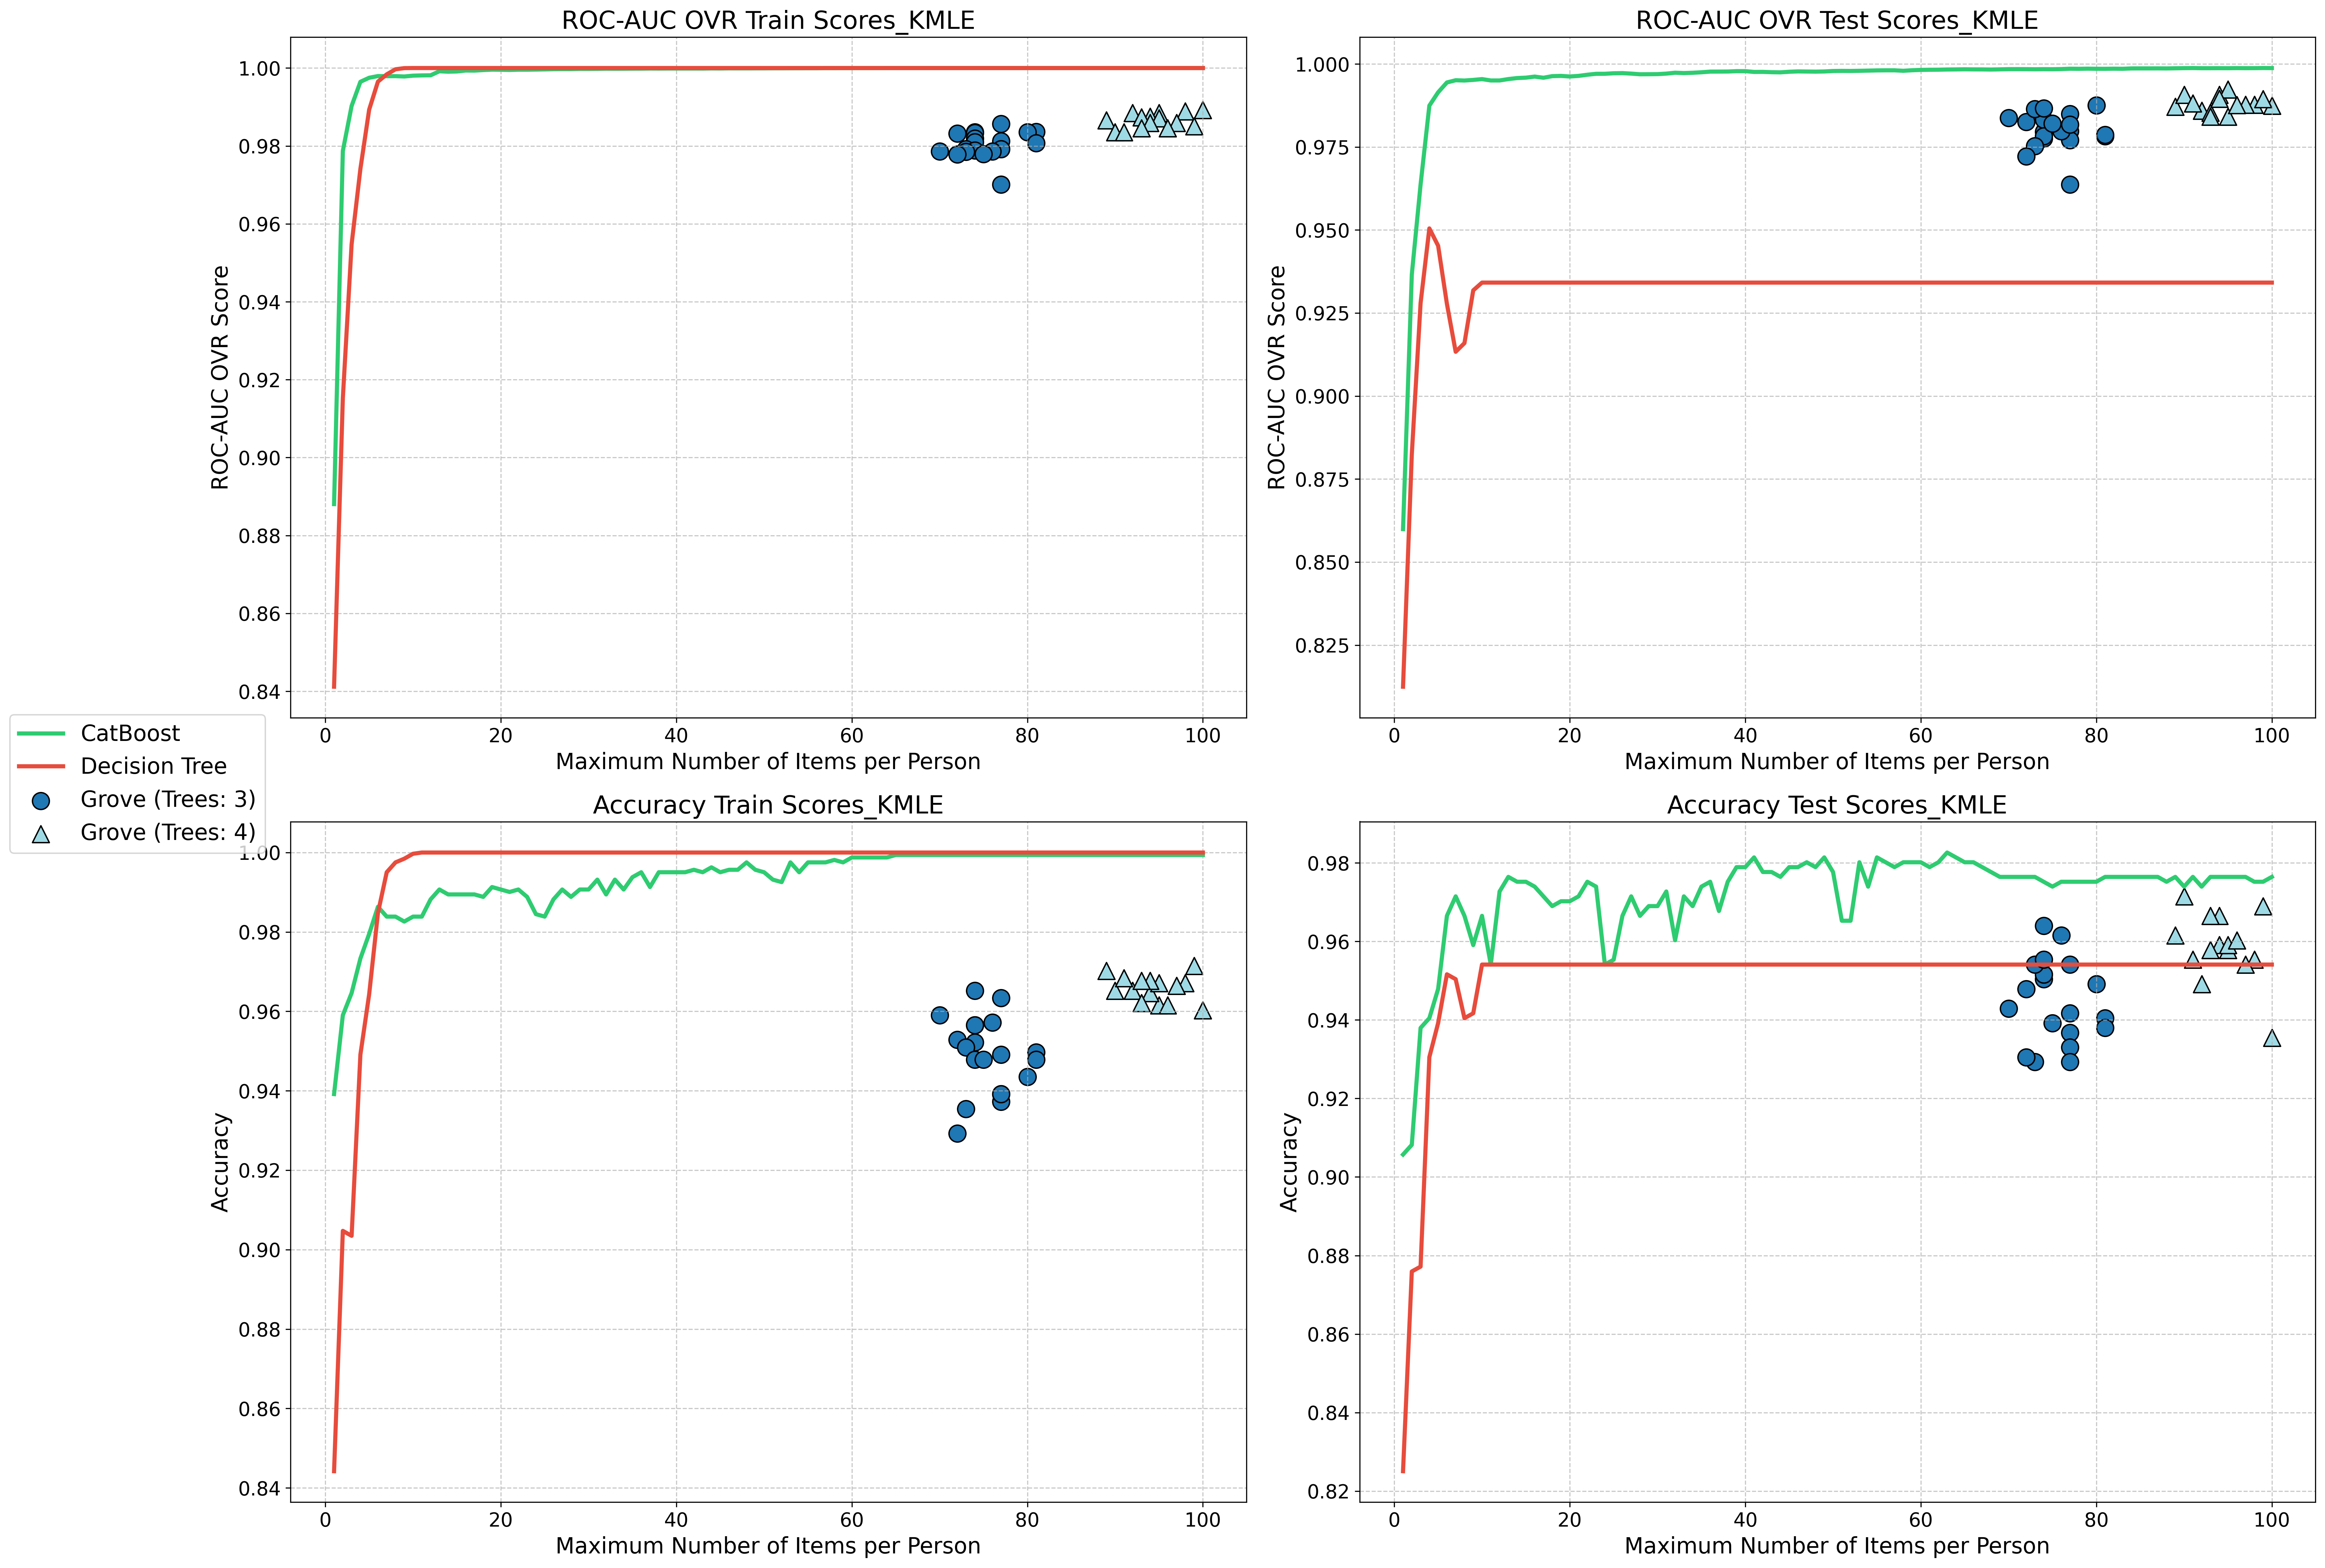

In [10]:
# 먼저 test set 분리 (전체의 20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# 80%의 데이터를 학습용/검증용 데이터로, 나머지 20%는 테스트 데이터로 분리

# 남은 데이터에서 train과 validation을 50:50으로 분리 (전체 기준으로는 80:20이 됨)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
# 나머지 80%의 데이터(X_temp, y_temp)를 학습용과 검증용으로 50:50 비율로 나누어, 최종적으로 전체 데이터 기준으로 60% 학습, 20% 검증이 되도록 설정

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_valid)}")
print(f"Test set size: {len(X_test)}")
# 각 데이터 세트의 크기를 출력

# 모델 설정
trees_num = 6 # catboost 트리 개수
max_depth = 10 # catboost 트리 최대 깊이

# CatBoost 모델 학습
## 학습률, 트리 개수, 최대 깊이를 제외하고 모두 default값을 사용
model, param = train_catboost(X_train, y_train, X_test, y_test,
                            max_depth=max_depth,
                            n_estimators=trees_num,
                            learning_rate=0.01, # 학습률
                            subsample=1,
                            min_child_samples=1,
                            random_state=42,
                            auto_class_weights=None)
# CatBoost 모델을 학습시키기 위해 설정된 매개변수로 모델 학습

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)
# 학습용 및 테스트용 데이터를 CatBoost의 Pool 객체로 변환 (Pool 객체는 CatBoost에서 데이터를 효율적으로 처리하기 위한 구조)

def optimal_threshold(y_true, y_pred):
    """예측 확률에 대한 최적의 임계값을 찾고 해당 accuracy를 반환합니다"""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # 해당 threshold에서의 accuracy 계산
    predictions = (y_pred >= optimal_threshold).astype(int)
    accuracy = accuracy_score(y_true, predictions)

    return optimal_threshold, accuracy
# ROC curve를 통해 최적의 임계값을 계산하고, 해당 임계값에서의 정확도를 반환하는 함수

# Grove 분석 먼저 실행
## 3개와 4개의 개별 트리로 이루어진 Grove 모델을 생성
print('Grove model evaluation...')
grove = Grove()
results = grove.analyze(param, X_valid, y_valid, model,
                       tree_range=(3, 4),
                       n_jobs=-1, percentile=100)
# Grove 모델을 사용하여, 3개 또는 4개의 트리로 이루어진 모델을 분석
# `analyze` 함수에서 주어진 트리 수 범위 내에서 최적의 트리 조합을 찾고 성능을 평가

# Grove 결과 계산
grove_points = []
for _, row in results.iterrows():
    prediction_result = grove.predict(
        param,
        X_train=X_valid,
        y_train=y_valid,
        X_test=X_test,
        y_test=y_test,
        model=model,
        tree_indices=row['Tree Indices']
    )
    # Grove 모델에서 예측을 수행하여, 각 트리 인덱스 조합에 대해 예측값을 구함

    opt_threshold, train_acc = optimal_threshold(y_valid, prediction_result['train_probas'])
    test_acc = accuracy_score(y_test, (prediction_result['test_probas'] >= opt_threshold).astype(int))
    # 최적의 임계값을 구하고, train 및 test accuracy 계산

    grove_points.append({
        'n_items': row['Total Items'],
        'train_auc': row['Model Performance'],
        'test_auc': roc_auc_score(y_test, prediction_result['test_probas']),
        'train_acc': train_acc,
        'test_acc': test_acc
    })
# 예측 결과를 `grove_points` 리스트에 저장, 각 Grove 모델에서의 성능 정보 포함

# Grove에서 얻은 최대 Total Items 값을 이용하여 반복 범위 설정
max_items = max(point['n_items'] for point in grove_points)
iteration_range = range(1, max_items + 1, 1)
# Grove 모델에서 얻은 최대 `Total Items` 값을 기준으로 반복 범위를 설정

# 결과 저장을 위한 딕셔너리들
cat_results = {
    'train_auc': {}, 'test_auc': {},
    'train_acc': {}, 'test_acc': {},
    'thresholds': {}
}

dt_results = {
    'train_auc': {}, 'test_auc': {},
    'train_acc': {}, 'test_acc': {},
    'thresholds': {}
}
# CatBoost 및 Decision Tree 모델에 대한 평가 결과를 저장할 딕셔너리 생성

# CatBoost 모델 평가
print('CatBoost model evaluation...')
cat_models = {}
y_pred_tests = {}

for n_tree in iteration_range:
    # 새로운 모델 학습 (지정된 트리 수만큼만)
    params = param.copy()
    params['iterations'] = n_tree
    cat_model = CatBoostClassifier(**params)
    cat_model.fit(train_pool, verbose=False)
    cat_models[n_tree] = cat_model
    # 지정된 트리 수만큼 모델을 학습시키고, 트리 수별로 모델을 저장

    # 예측
    y_pred_train = cat_model.predict_proba(X_train)[:, 1]
    y_pred_test = cat_model.predict_proba(X_test)[:, 1]
    y_pred_tests[n_tree] = y_pred_test
    # 학습용 및 테스트용 데이터에 대해 예측값을 계산

    # AUC 점수 계산
    train_auc = roc_auc_score(y_train, y_pred_train)
    test_auc = roc_auc_score(y_test, y_pred_test)

    # 최적 임계값 찾기
    opt_threshold, train_acc = optimal_threshold(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, (y_pred_test >= opt_threshold).astype(int))
    # 최적 임계값을 찾고, 해당 임계값을 사용하여 정확도 계산

    # 결과 저장
    cat_results['train_auc'][n_tree] = train_auc
    cat_results['test_auc'][n_tree] = test_auc
    cat_results['train_acc'][n_tree] = train_acc
    cat_results['test_acc'][n_tree] = test_acc
    cat_results['thresholds'][n_tree] = opt_threshold
# CatBoost 모델에 대한 성능 (AUC, Accuracy 등)과 최적 임계값을 저장

# Decision Tree 학습 및 평가
print('Decision Tree model evaluation...')
dt_models = {}
dt_pred_tests = {}

for max_depth in iteration_range:
    dt_model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt_model.fit(X_temp, y_temp)
    dt_models[max_depth] = dt_model
    # Decision Tree 모델을 트리 깊이 별로 학습시킴

    y_pred_train = dt_model.predict_proba(X_temp)[:, 1]
    y_pred_test = dt_model.predict_proba(X_test)[:, 1]
    dt_pred_tests[max_depth] = y_pred_test
    # 학습용 및 테스트용 데이터에 대해 예측값을 계산

    train_auc = roc_auc_score(y_temp, y_pred_train)
    test_auc = roc_auc_score(y_test, y_pred_test)

    opt_threshold, train_acc = optimal_threshold(y_temp, y_pred_train)
    test_acc = accuracy_score(y_test, (y_pred_test >= opt_threshold).astype(int))
    # AUC 점수 계산 및 최적 임계값을 사용하여 정확도 계산

    dt_results['train_auc'][max_depth] = train_auc
    dt_results['test_auc'][max_depth] = test_auc
    dt_results['train_acc'][max_depth] = train_acc
    dt_results['test_acc'][max_depth] = test_acc
    dt_results['thresholds'][max_depth] = opt_threshold
# Decision Tree 모델에 대한 성능 (AUC, Accuracy 등)과 최적 임계값을 저장

print('Done', '\n')
grove_x = [p['n_items'] for p in grove_points]
grove_tree_counts = [len(r['Tree Indices']) for _, r in results.iterrows()]
# Grove 모델의 `n_items`와 트리 개수를 각각 추출하여 그래프에서 사용할 값 생성

# 그래프의 스타일 설정
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 12

# 여러 개의 그래프를 그리기 위한 2x2 서브플롯 생성
fig, axes = plt.subplots(2, 2, figsize=(24, 16), dpi=300)

# 트리 개수별로 색상과 모양 설정
unique_tree_counts = sorted(set(grove_tree_counts))
colors = cm.get_cmap('tab20', len(unique_tree_counts))
markers = ['o', '^', 's', 'D', 'P', 'X', '*', 'h', '+', 'x']
marker_dict = {count: markers[i % len(markers)] for i, count in enumerate(unique_tree_counts)}

# 그래프 설정 목록
graphs = [
    ('ROC-AUC OVR Train Scores_KMLE', 'train_auc', 'ROC-AUC OVR Score'),
    ('ROC-AUC OVR Test Scores_KMLE', 'test_auc', 'ROC-AUC OVR Score'),
    ('Accuracy Train Scores_KMLE', 'train_acc', 'Accuracy'),
    ('Accuracy Test Scores_KMLE', 'test_acc', 'Accuracy')
]

# 각 그래프에 대해 데이터 시각화
for ax, (title, metric_key, ylabel) in zip(axes.flatten(), graphs):
    ax.plot(cat_results[metric_key].keys(), cat_results[metric_key].values(),
            label='CatBoost', linestyle='-', color='#2ecc71', linewidth=3)
    ax.plot(dt_results[metric_key].keys(), dt_results[metric_key].values(),
            label='Decision Tree', linestyle='-', color='#e74c3c', linewidth=3)

    # Grove 포인트를 트리 개수별로 구분하여 scatter
    for idx, tree_count in enumerate(unique_tree_counts):
        xs = [x for x, c in zip(grove_x, grove_tree_counts) if c == tree_count]
        ys = [p[metric_key] for p, c in zip(grove_points, grove_tree_counts) if c == tree_count]
        ax.scatter(xs, ys, marker=marker_dict[tree_count], color=colors(idx),
                   label=f'Grove (Trees: {tree_count})', s=150, edgecolor='black')

    ax.set_title(title)
    ax.set_xlabel('Maximum Number of Items per Person')
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle='--', alpha=0.7)

# 범례 설정
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(-0.08, 0.5), fontsize=16)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('grove_tree_count_visualization_marker_KMLE.png', dpi=300, bbox_inches='tight')
plt.show()
# 각 모델의 성능을 시각적으로 비교하고, Grove 모델에서 얻은 트리 개수별로 성능 차이를 시각화하여 이미지 파일로 저장
